In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import os
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import ipysheet
import colorsys
import xlsxwriter
import csv
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import sys
import itertools
import time
from scipy import signal
from datetime import datetime

In [2]:
# import python CWL files

module_path = os.path.abspath(os.path.join('/SSB'))
if module_path not in sys.path:
    sys.path.append(module_path)

from od_matrices import run, collect_groups, to_groups, plot_od_pixmap, compute_matrix_norms,collect_matrix_entries, generate_hist_plot, generate_bar_plot

module_path = os.path.abspath(os.path.join('../../python/python_src_preprocessing/target_learning'))
if module_path not in sys.path:
    sys.path.append(module_path)

from preprocessing.preprocessing import add_pedestrian_to_field, gaussian_pdf
import plotting.densitymap as densitymap 


# To-Do's

- ~~generate new mapping file~~
- load all pedestrian data (with new mapping)
- divide into 10 second groups
- sort out groups with ped count < 50
- add time sequences option for denstiy maps
- Generate density maps 


## Generate new mapping 

New mapping will move all combinations to -1,-1 which have a smaller pedestrian count than 0.001% of the total day. Combinations to be removed are in the file removed_mappings.csv

In [3]:
radius = 1 # TODO: This parameter is uncertain
ped_radius = 0.195 # TODO: This parameter is uncertain
signma = 0.7

# TODO: add changes to this method to the pre-processing file
def gauss_filter():
    x_range = np.linspace(-1,1,5)
    xx, yy = np.meshgrid(x_range,x_range, sparse=False)
    grid = np.sqrt(np.square(xx) + np.square(yy))
    gauss = np.vectorize(gaussian_pdf)
    gauss_grid = gauss(signma, grid, ped_radius)
    return gauss_grid

# This method was transfered from vadere java to python
# Adds the position of a pedestrian to a matrix
# pedestrian is split between 4 cells using interpolation
# max value of a pedestran is 1
# position_matrix : 2d matrix containing the positions of every pedestrian (matrix is updated not overwritten)
# x,y : trajectory coordinates for single pedestrian
def mapp_ped_positions(position_matrix, x,y, res):
    lowerLeftX = int((x-1)/res)
    lowerLeftY = int((y-1)/res)
    cordX = x/res
    cordY = y/res
    
    dx = abs(cordX - lowerLeftX)
    dy = abs(cordY - lowerLeftY)
    
    w1 = dx*dy
    w2 = dx*(1-dy)
    w3 = (1-dx)*dy
    w4 = (1-dx)*(1-dy)
    
    if not np.less_equal(w1+w2+w3+w4,1.0):
        print("error w1+w2+w3+w4 should be 1 but is ",w1+w2+w3+w4)
    
    position_matrix[lowerLeftY-1,lowerLeftX-1] += w1
    position_matrix[lowerLeftY, lowerLeftX-1] += w2
    position_matrix[lowerLeftY-1, lowerLeftX] += w3
    position_matrix[lowerLeftY, lowerLeftX] += w4
    
    return position_matrix

In [4]:
day = "20190905"
base = '/media/veracrypt1/objectstream_{0}/'.format(day)
# 6 7 8 9 10 11 12 13 14 15 16 17 18 19
new_dir = "csv{0}".format(day)
if new_dir not in os.listdir(): 
    os.makedirs(new_dir)
    
    
mapping = pd.read_csv(os.path.join(base, 'mapping_removed.csv'), dtype={'pedestrianId': 'str'})

## Generate Density Maps and OD-Matrices

- OD-matrix every 10s time interval
- Density maps for every 2s in a 10s interval

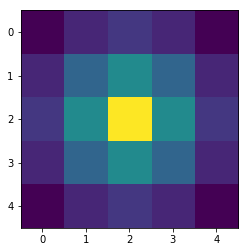

selected hours [9]


In [5]:
# compute gaussian filter
gsfilter = gauss_filter()
plt.imshow(gsfilter)
plt.show()

# maximum domain size
x_offset = 47000
y_offset = 10000
width = 54000 # measurment in mm -> reduced by resolution of res=500
height = 19000 # measurment in mm -> reduced by resolution of res=500

resolution = 500

matrix_size = (height//resolution,width//resolution)

# concaternate all selected hours of one day
hours = list(range(9,10))
print("selected hours",hours)

Step 1 :  34.56127309799194
max val 0.09627032440819562


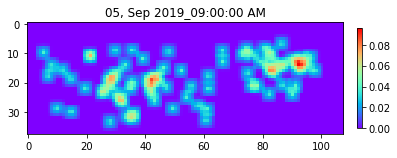

max val 0.10468042550956552


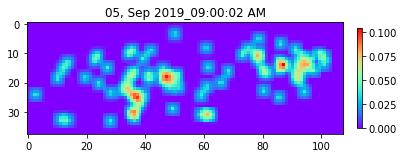

max val 0.09065879313353585


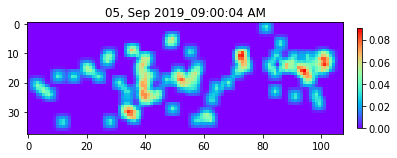

max val 0.10483944532070583


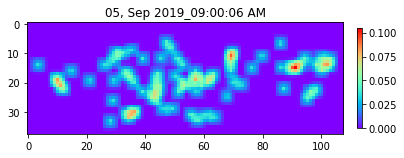

max val 0.08951739778416737


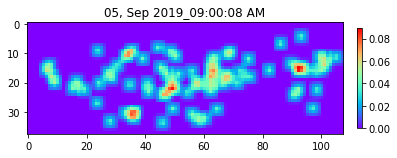

error w1+w2+w3+w4 should be 1 but is  1.0000000000000002
error w1+w2+w3+w4 should be 1 but is  1.0000000000000002
error w1+w2+w3+w4 should be 1 but is  1.0000000000000002
error w1+w2+w3+w4 should be 1 but is  1.0000000000000002
error w1+w2+w3+w4 should be 1 but is  1.0000000000000002
error w1+w2+w3+w4 should be 1 but is  1.0000000000000002
error w1+w2+w3+w4 should be 1 but is  1.0000000000000002
error w1+w2+w3+w4 should be 1 but is  1.0000000000000002
error w1+w2+w3+w4 should be 1 but is  1.0000000000000002
error w1+w2+w3+w4 should be 1 but is  1.0000000000000002
error w1+w2+w3+w4 should be 1 but is  1.0000000000000002
error w1+w2+w3+w4 should be 1 but is  1.0000000000000002
error w1+w2+w3+w4 should be 1 but is  1.0000000000000002
error w1+w2+w3+w4 should be 1 but is  1.0000000000000002
error w1+w2+w3+w4 should be 1 but is  1.0000000000000002
error w1+w2+w3+w4 should be 1 but is  1.0000000000000002
error w1+w2+w3+w4 should be 1 but is  1.0000000000000002
error w1+w2+w3+w4 should be 1 b

In [14]:
test_output = 0
# counters
full_interval = 0
missing_interval = 0
pedestian_count = []
# assertions
test = True
# store info
info_group = [] # store date, start and end times for groups
info_subgroup = [] # store date, start and end times for subgroups

#output_file = open('density_maps-{0}-{1}.csv'.format(day, datetime.now()), 'a', newline='')
#outwriter = csv.writer(output_file, delimiter=',')
for h in hours:
    tick0 = time.time() # measure time to process one hour
    frame = pd.read_csv(os.path.join(base, 'hours', 'hour-{0}.csv'.format(h)), dtype={'pedestrianId': 'str'})
    frame.x = frame.x.add(x_offset) # transform coordinates such that origin is (0,0) at lower left corner 
    frame.y = frame.y.add(y_offset)
    # divide pedestrians into 10s intervals, generate od-matrix
    groups, od_matrices, origins_str, destinations_str = collect_groups(frame, mapping, ('S', 10, 1, 0))
    tick1 = time.time()
    print("Step 1 : ", time.time()-tick0)
    tick0 = time.time()
    
    for group in groups: # divide in 10 second intervals
        ped_count = len(group.pedestrianId.unique())
        pedestian_count.append(ped_count)
        start_g = group.datetime.iloc[0]
        end_g = group.datetime.iloc[-1]
        sub_groups = to_groups(group, 1, 'S', 1, 0)
        info_group.append('{:%d, %b %Y}_{:%I:%M:%S %p}_{:%I:%M:%S %p}'.format(start_g,start_g,end_g))
        lengths = [len(sub) for sub in sub_groups]
            
        if ped_count < 50 or 0 in lengths:  # compute density if ped count < threshold and all time steps exist
            continue

        density_maps = []
        for s in range(0,len(sub_groups)): # divide in 1 second intervals
            sub_group = sub_groups[s]
            if np.mod(s,2) != 0:
                continue
            
            start_sg = sub_group.datetime.iloc[0]
            end_sg = sub_group.datetime.iloc[-1]
            info_subgroup.append('{:%d, %b %Y}_{:%I:%M:%S %p}'.format(start_sg,start_sg))
            pedestrian_matrix = np.zeros(matrix_size)
            x_cords = sub_group['x'].values.tolist()
            y_cords = sub_group['y'].values.tolist()
            
            for k in range(0,len(x_cords)):
                pedestrian_matrix = mapp_ped_positions(pedestrian_matrix, x_cords[k],y_cords[k], resolution)
            
            density_map = signal.convolve2d(pedestrian_matrix,gsfilter, mode='same')
            if test_output == 0:
                plt.imshow(density_map, cmap='rainbow')
                plt.title(info_subgroup[-1])
                #plt.clim(0,0.5)
                print("max val", np.max(density_map))
                plt.colorbar(fraction=0.015, pad=0.04)
                plt.savefig("{0}.png".format(info_subgroup[-1]))
                plt.show()
            
            density_maps.append(density_map.flatten('C')) 
            
            # make sure every pedestrian is only once inside 1s interval (otherwise he would be added twice!)
            test = sub_group['pedestrianId'].duplicated().any() 
            if test:
                print("1s interval contains the same pedestrian twice", boolean)
                print(sub_group.head(20))
        
        full_interval += 1
        #print("finished {0}".format(info_group[-1]))
        test_output = 1
        
        # write to file
        #outwriter.writerow(np.concatenate(density_maps))
        
    print("Step 2 :",time.time()-tick0)
    print("total intervals: 360","Used intervals:",full_interval, "Discarded intervals (ether ped count < or missing timestep):",360-full_interval)
    print("time intervals with missing time steps", missing_interval)

#output_file.close()


#### figure showing pedestrian count over selected hours

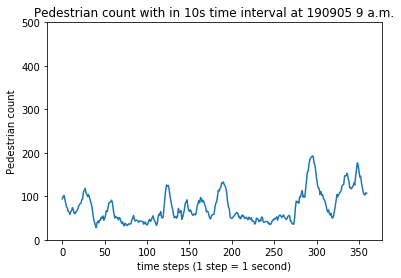

In [15]:
plt.title("Pedestrian count with in 10s time interval at 190905 9 a.m.")
plt.ylabel("Pedestrian count")
plt.xlabel("time steps (1 step = 1 second)")
plt.plot(list(range(0,360)),pedestian_count)
plt.ylim([0,500])
plt.savefig("ped_count_{0}_9am.png".format(day), dpi=500)
plt.show()

In [ ]:
#maxx = frame.x.max()
#minx = frame.x.min()
#maxy = frame.y.max()
#miny = frame.y.min()
#print(minx,maxx,miny,maxy)
    